# Ficha nr1 - Fashion mnist MLP


**Ruben Silva** - pg57900


### Imports

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import (
    Linear, ReLU, Softmax, CrossEntropyLoss
)
from torch.nn.init import xavier_uniform_
from torchinfo import summary

# Torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Live loss plot
from livelossplot import PlotLosses

# Sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Outros
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


### Paths

In [2]:
PATH_TRAIN = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC1 CNN fashion mnist\\dataset\\mnist_train.csv'
PATH_TEST = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC1 CNN fashion mnist\\dataset\\mnist_test.csv'

## Tarefa 1 - MLP

**Setup**

In [3]:
device = torch.device("cpu")
BATCH_SIZE = 32


**Prepare Data**

In [4]:
class CSVDataset(Dataset):
    def __init__(self, path_train, path_test):
        df_train = pd.read_csv(path_train, header=0)
        df_test = pd.read_csv(path_test, header=0)
        self.x_train = df_train.values[:, 1:]
        self.y_train = df_train.values[:, 0]
        self.x_test = df_test.values[:, 1:]
        self.y_test = df_test.values[:, 0]
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.y_train = self.y_train.astype('long')
        self.y_test = self.y_test.astype('long')

    def __len_train__(self):
        return len(self.x_train)
    
    def __len_test__(self):
        return len(self.x_test)
    
    def __getitem_train__(self, idx):
        return [self.x_train[idx], self.y_train[idx]]
    
    def __getitem_test__(self, idx):
        return [self.x_test[idx], self.y_test[idx]]
    
    def get_splits_flat(self):
        x_train = torch.from_numpy(np.array(self.x_train))
        y_train = torch.from_numpy(np.array(self.y_train)).long()  # Explicitly cast to long
        x_test = torch.from_numpy(np.array(self.x_test))
        y_test = torch.from_numpy(np.array(self.y_test)).long()    # Explicitly cast to long
        train = torch.utils.data.TensorDataset(x_train, y_train)
        test = torch.utils.data.TensorDataset(x_test, y_test)
        return train, test


In [5]:
def prepare_data_flat(path_train, path_test):
    dataset = CSVDataset(path_train, path_test)
    train, test = dataset.get_splits_flat()
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data_flat(PATH_TRAIN, PATH_TEST)


**Visualize Data**

In [6]:
def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)
def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)

    
visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)


,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:59999
Quantidade de casos de Teste:9999
Shape tensor batch casos treino, input: torch.Size([32, 784]), output: torch.Size([32])
Shape tensor batch casos test, input: torch.Size([32, 784]), output: torch.Size([32])
tensor([2, 2, 3, 2, 6, 5, 1, 2, 8, 2, 6, 1, 2, 0, 1, 2, 2, 5, 3, 2, 7, 3, 2, 8,
        9, 1, 2, 7, 3, 9, 3, 4])


torch.Size([32, 784])
torch.Size([32, 1, 28, 28])


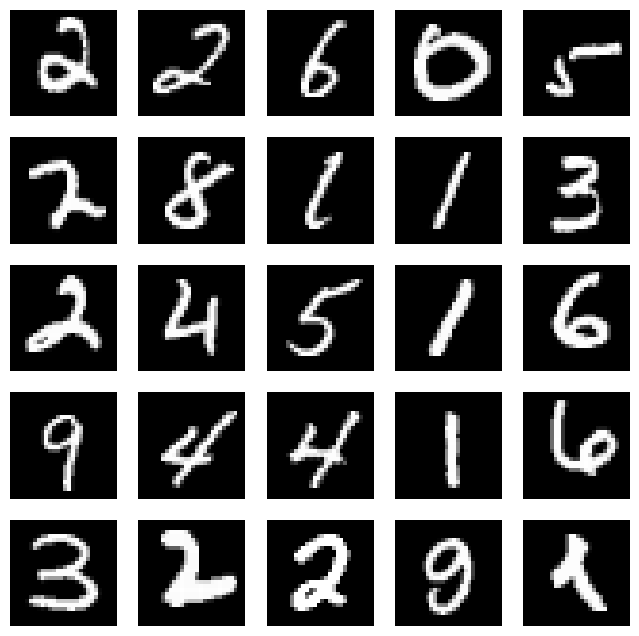

In [7]:
def visualize_mnist_images_flat(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(False)  #b=None
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()

visualize_mnist_images_flat(train_dl)


-----Train------
casos: 59999
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[5923 6742 5958 6131 5842 5420 5918 6265 5851 5949]
59999


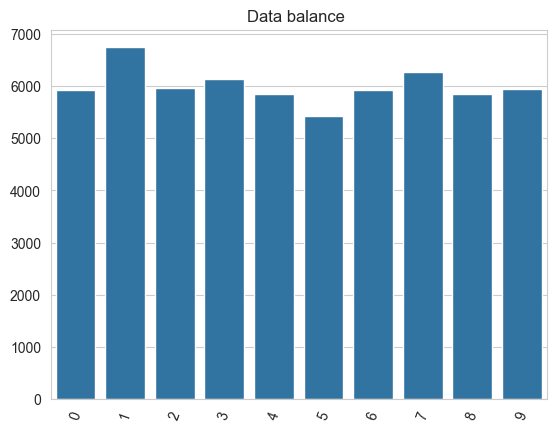

-----Test------
casos: 9999
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[ 980 1135 1032 1010  982  892  958 1027  974 1009]
9999


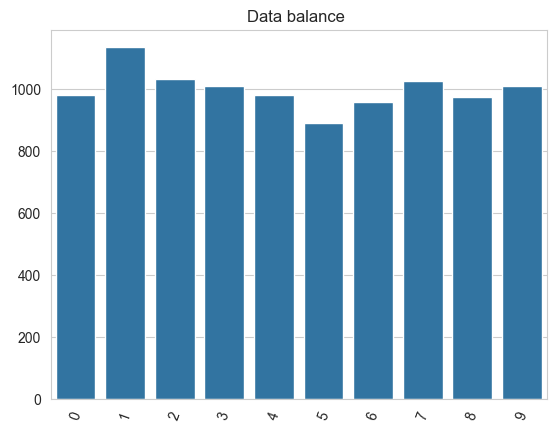

In [8]:
def visualize_holdout_balance(dl):
    _, labels = next(iter(dl))                            
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico = sns.barplot(x=x, y=y)
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.show()
     
print("-----Train------")   
visualize_holdout_balance(train_dl_all)
print("-----Test------") 
visualize_holdout_balance(test_dl_all)


**Model**

In [9]:
class MLP(nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        
        # First hidden layer: 784 inputs to 128 units
        self.hidden1 = Linear(n_inputs, 128)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = ReLU()
        
        # Second hidden layer: 128 units to 64 units
        self.hidden2 = Linear(128, 64)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = ReLU()
        
        # Third hidden layer: 64 units to 20 units
        self.hidden3 = Linear(64, 20)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = ReLU()
        
        # Output layer: 20 units to 10 classes
        self.hidden4 = Linear(20, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)  

    def forward(self, X):
        # Flatten input if necessary (batch_size, 784)
        X = X.view(-1, 784)
        
        X = self.hidden1(X)
        X = self.act1(X)
        
        X = self.hidden2(X)
        X = self.act2(X)
        
        X = self.hidden3(X)
        X = self.act3(X)
        
        X = self.hidden4(X)
        X = self.act4(X)
        
        return X

# Instantiate the model
model = MLP(784)
print(summary(model, input_size=(BATCH_SIZE, 784), verbose=0))
model.to(device)


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 10]                  --
├─Linear: 1-1                            [32, 128]                 100,480
├─ReLU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 64]                  8,256
├─ReLU: 1-4                              [32, 64]                  --
├─Linear: 1-5                            [32, 20]                  1,300
├─ReLU: 1-6                              [32, 20]                  --
├─Linear: 1-7                            [32, 10]                  210
├─Softmax: 1-8                           [32, 10]                  --
Total params: 110,246
Trainable params: 110,246
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.53
Input size (MB): 0.10
Forward/backward pass size (MB): 0.06
Params size (MB): 0.44
Estimated Total Size (MB): 0.60


MLP(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=64, out_features=20, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=20, out_features=10, bias=True)
  (act4): Softmax(dim=1)
)

**Train Model**

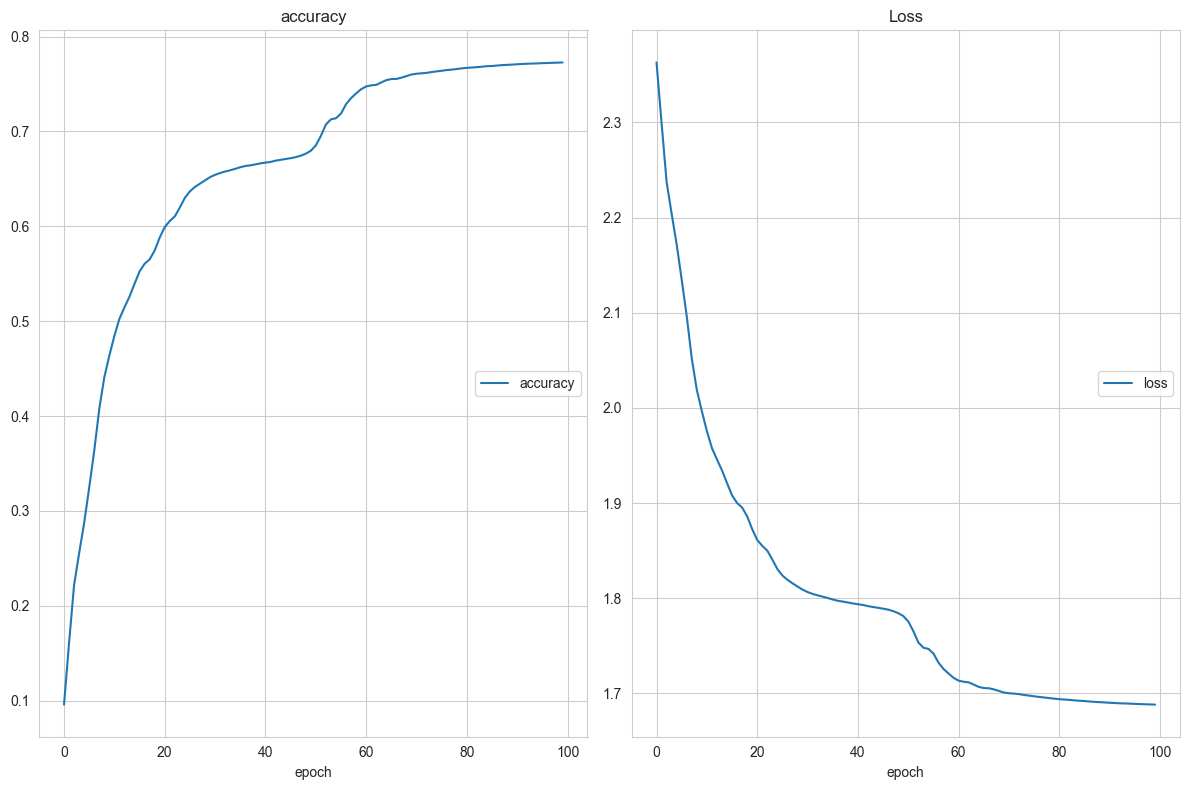

accuracy
	accuracy         	 (min:    0.096, max:    0.773, cur:    0.773)
Loss
	loss             	 (min:    1.688, max:    2.363, cur:    1.688)


In [10]:
EPOCHS = 100
LEARNING_RATE = 0.001

def train_model(train_dl, model):
    liveloss = PlotLosses()    
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0 
        epoch_acc  = 0 
        for i, (inputs, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc
            print(f'Epoch {epoch:03}:| Loss: {epoch_loss/len(train_dl):.5f}| Acc: {epoch_acc/len(train_dl):.3f}')      
            logs['loss'] = epoch_loss
            logs['accuracy'] = epoch_acc/len(train_dl)
            liveloss.update(logs)
            liveloss.send()

train_model(train_dl_all, model)


**Evaluate Model**

In [11]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

Accuracy: 0.765

acertou:7654 falhou:2345
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       980
           1       0.96      0.99      0.97      1135
           2       0.59      0.95      0.73      1032
           3       0.00      0.00      0.00      1010
           4       0.92      0.94      0.93       982
           5       0.48      0.96      0.64       892
           6       0.91      0.96      0.93       958
           7       0.89      0.94      0.91      1027
           8       0.00      0.00      0.00       974
           9       0.78      0.92      0.84      1009

    accuracy                           0.77      9999
   macro avg       0.64      0.76      0.69      9999
weighted avg       0.65      0.77      0.69      9999

[[ 964    0    2    0    0    6    5    2    0    1]
 [   0 1119    9    0    0    3    2    1    1    0]
 [  11    2  981    0   11    3    9   13    0    2]
 [   9    4  326    0    0  588    2   4

c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

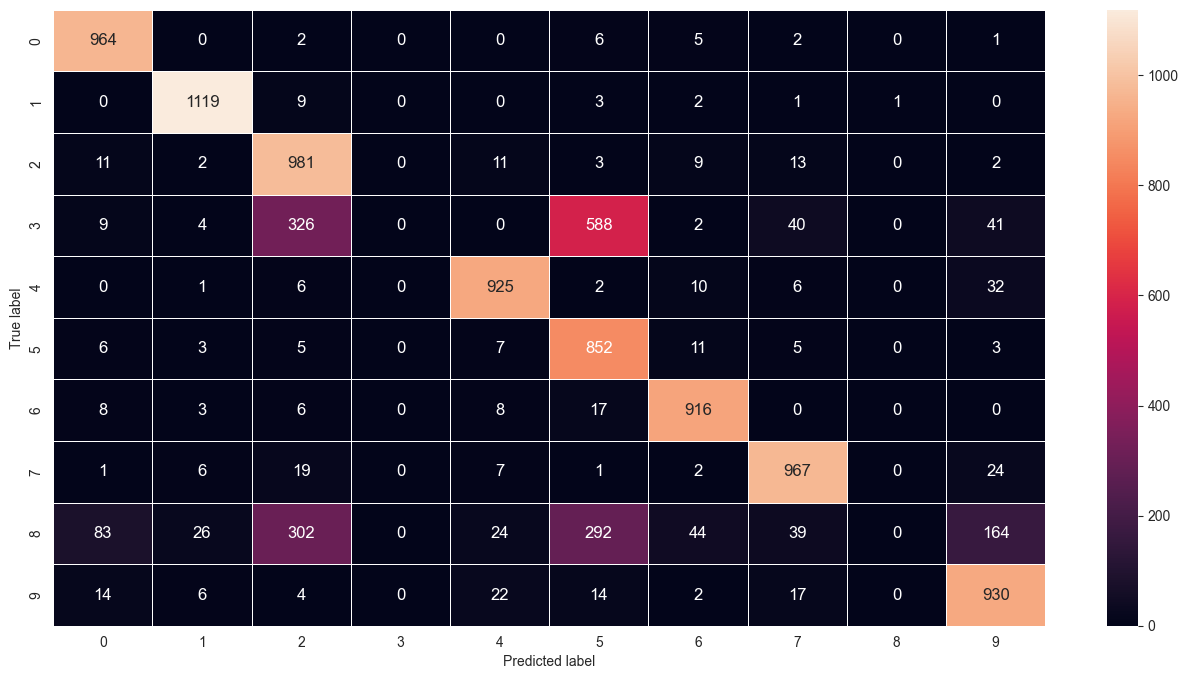

21

In [12]:
def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, 
        fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

actual_values, predictions = evaluate_model(test_dl, model)
acertou=0
falhou = 0

for r,p in zip(actual_values, predictions):
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=list(cr.keys())[0:10]
cm = confusion_matrix(actual_values, predictions)
print (cm)
display_confusion_matrix(cm,list_classes)
21


**Use Model**

torch.Size([32, 784])
torch.float32
predict: 2


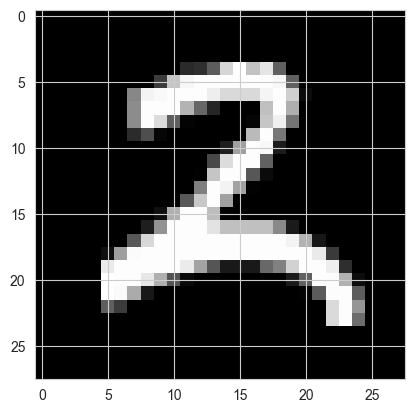

In [13]:
def make_prediction(model, img_list, idx):
    print(img_list.shape)
    print(img_list.dtype)
    img_list = img_list.to(device)
    prediction = model(img_list).detach().numpy()[idx].argmax()
    print("predict:",prediction)
    img = img_list[idx].reshape(1,28, 28)
    plt.imshow(img[0], cmap=plt.get_cmap('gray'))
    plt.show()
_, (inputs, targets) = next(enumerate(test_dl))
make_prediction(model,inputs, 10)
